# Tweet Sentiment Analysis
---

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

#Import WordCloud
from wordcloud import WordCloud, STOPWORDS
from scipy import stats

In [2]:
# Remove unwanted patterns
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tywang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tywang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

In [4]:
# Tweet Cleaner
stopwordlist = set(stopwords.words("english"))
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def remove_stopwords(tweet):
    new_tweet = [w for w in tweet.split() if not w in stopwordlist] 
    return (" ").join(new_tweet) 

def remove_specialchar(tweet):
    #Converts HTML tags to the characters they represent
    soup = BeautifulSoup(tweet, "html.parser")
    tweet = soup.get_text()
    
    #Convert www.* or https?://* to empty strings
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) 
    #Convert @username to empty strings
    tweet = re.sub('@[^\s]+','',tweet)

    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('[\n]+', ' ', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #Trims the tweet
    tweet = tweet.strip('\'"')
    
    #Remove all char not alphabets, num or whitespaces
    tweet = re.sub('[^A-Za-z0-9 ]+','', tweet)
    
    return tweet


#Attempts to replace every individual word with it's root word.
def stemmer_lemmatizer(tweet):
    word_list = []
    for word in tweet.split():
        word = ps.stem(word)
        word = wordnet_lemmatizer.lemmatize(word)
        word_list.append(word)
    return (" ".join(word_list))

#for testing
#Tweets = df_oba['Tweet'].values
#for i in range(len(Tweets)):
#    print(i)
#    b = remove_specialchar(Tweets[i])
#    a = stemmer_lemmatizer(b)
#    print('last', a)
#    print('last', remove_stopwords(a))


In [5]:
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",
    
    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    #punctuation:'',
    '\s+':' ', # replace multi space with one single space
}

In [6]:
def load_csv():
    xls = pd.ExcelFile('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/training-Obama-Romney-tweets.xlsx')
    df1 = pd.read_excel(xls, 'Obama')
    df2 = pd.read_excel(xls, 'Romney')
    return df1, df2

def data_parse(df):
    
    #drop missing values and rename columns
    df = df.iloc[1:, 3:5]
    df = df.rename(columns = {'Anootated tweet':'Tweet', 'Unnamed: 4': 'Class'})
    # Drop rows if Tweet is empty
    df.dropna(subset = ['Tweet'], inplace=True)
    print(df.shape)
    
    #dtype class label
    df['Class'] = df['Class'].astype(str)
    df['Tweet'] = df['Tweet'].astype(str)
    print(df.info())
    print(df['Class'].value_counts())

    # Extract rows where class labels -1, 0, 1
    df = df[ (df['Class'] == '0') |(df['Class'] == '-1') | (df['Class'] == '1') ]
    print('After extracting:', df.shape)
    
    tweets = df['Tweet'].values
    targets = df['Class'].values
    
    return tweets, targets

def tweet_cleaning(tweets, flag):
    
    for i in range(len(tweets)):
        #print(i)
        #print('original:', tweets[i])
        tweets[i] = tweets[i].lower()
        #if tweets[i] in abbr_dict.keys():
        #    tweets[i].replace(abbr_dict,regex=True,inplace=True)
        
        #tweets[i] = ' '.join(filter(lambda x: x.isalpha(), ''.join(tweets[i])))
        tweets[i] = remove_specialchar(tweets[i])
        if flag == 'stem_lem':
            tweets[i] = stemmer_lemmatizer(tweets[i])
        if flag == 'rm_stopwords':
            tweets[i] = remove_stopwords(tweets[i])
        if flag == 'all':
            tmp = remove_specialchar(tweets[i])
            tmp = stemmer_lemmatizer(tmp)
            tweets[i] = remove_stopwords(tmp)
        #tmp = remove_specialchar(tweets[i])
        #tmp = stemmer_lemmatizer(tmp)
        #tweets[i] = remove_stopwords(tmp)
        #print('final:', tweets[i])
    return tweets

In [41]:
# tweets_oba[10]

In [7]:
def save_dataset(tweets, targets, tw_name, tar_name):
    print('Saving training dataset...')
    
    #Create Saving Files
    if not os.path.exists('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData'):
        os.makedirs('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData')
        
    np.save('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/' + tw_name + '.npy', tweets)
    np.save('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/' + tar_name + '.npy', targets)

    print('Saved parsed dataset')
    

In [8]:
def wordcloud(data,backgroundcolor = 'white', width = 400, height = 150):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [9]:
df1, df2 = load_csv()

## Obama's Tweets

In [10]:
tweets_oba, targets_oba = data_parse(df1)
tweets_oba.shape, targets_oba.shape

(7196, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7196 entries, 1 to 7198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7196 non-null   object
 1   Class   7196 non-null   object
dtypes: object(2)
memory usage: 168.7+ KB
None
0             1977
-1            1968
1             1679
2             1543
irrevelant      23
nan              5
irrelevant       1
Name: Class, dtype: int64
After extracting: (5624, 2)


((5624,), (5624,))

In [11]:
tweets_oba

array(["Kirkpatrick, who wore a baseball cap embroidered with Barack Obama's signature and had the hangdog look of Jason segel - Courier Journal",
       '#<e>obama</e> debates that Cracker Ass Cracker tonight... I will be tuned in! #TeamObama',
       '@Hollivan @hereistheanswer  Youre missing the point  Im afraid you do not understand the bigger picture if you dont care if Obama re elected',
       ...,
       ' The Reason <e>Ann Romney</e> And <e>Michelle Obama</e> Matched <a>Last Night</a>: <e>Michelle Obama</e> and <e>Ann Romney</e> showed up to last nig... http://t.co/lRXmH4Ka                           ',
       ' <e>Obama</e> Kenakan Cincin Syahadat Sejak SMA? http://t.co/HQw4rfqx                           ',
       ' Bitches be like "Obama<3" bitches just want <a>food stamps</a> lmao _Ù÷â                           '],
      dtype=object)

## WordCloud for Oba_Tweet

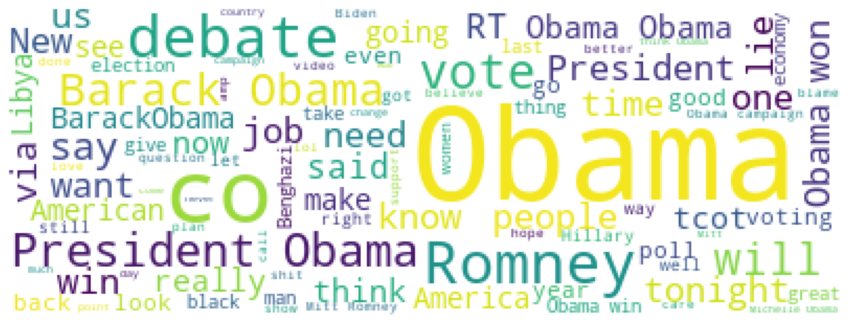

In [12]:
#Original Tweet
wordcloud(''.join(tweets_oba))

['kirkpatrick who wore a baseball cap embroidered with barack obamas signature and had the hangdog look of jason segel  courier journal'
 'obama debates that cracker ass cracker tonight i will be tuned in teamobama'
 ' youre missing the point im afraid you do not understand the bigger picture if you dont care if obama re elected'
 ...
 ' the reason ann romney and michelle obama matched last night michelle obama and ann romney showed up to last nig '
 ' obama kenakan cincin syahadat sejak sma '
 ' bitches be like obama3 bitches just want food stamps lmao  ']


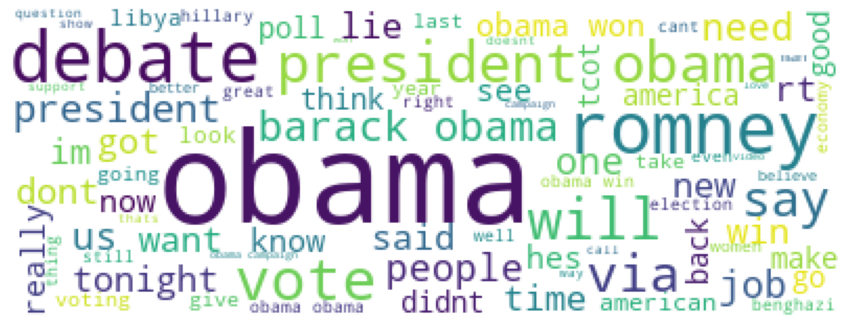

In [13]:
# Remove special char only
oba_rmspecial = tweet_cleaning(tweets_oba, '')
print(oba_rmspecial)
wordcloud(''.join(oba_rmspecial))

['kirkpatrick who wore a basebal cap embroid with barack obama signatur and had the hangdog look of jason segel courier journal'
 'obama debat that cracker as cracker tonight i will be tune in teamobama'
 'your miss the point im afraid you do not understand the bigger pictur if you dont care if obama re elect'
 ...
 'the reason ann romney and michel obama match last night michel obama and ann romney show up to last nig'
 'obama kenakan cincin syahadat sejak sma'
 'bitch be like obama3 bitch just want food stamp lmao']


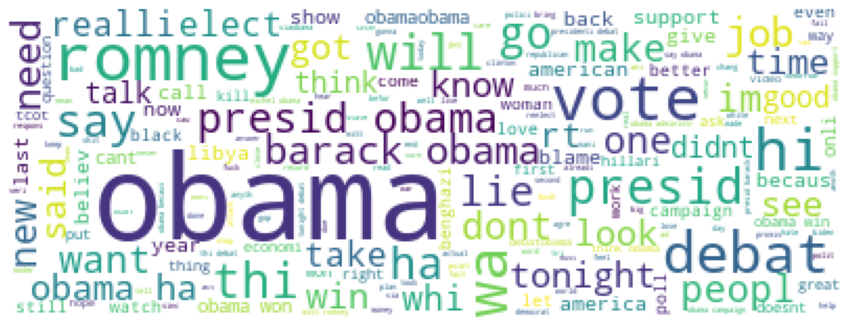

In [14]:
# Tweet stemmer_lemmatizer
oba_stemlem = tweet_cleaning(tweets_oba, 'stem_lem')
print(oba_stemlem)
wordcloud(''.join(oba_stemlem))

['kirkpatrick wore basebal cap embroid barack obama signatur hangdog look jason segel courier journal'
 'obama debat cracker cracker tonight tune teamobama'
 'miss point im afraid understand bigger pictur dont care obama elect' ...
 'reason ann romney michel obama match last night michel obama ann romney show last nig'
 'obama kenakan cincin syahadat sejak sma'
 'bitch like obama3 bitch want food stamp lmao']


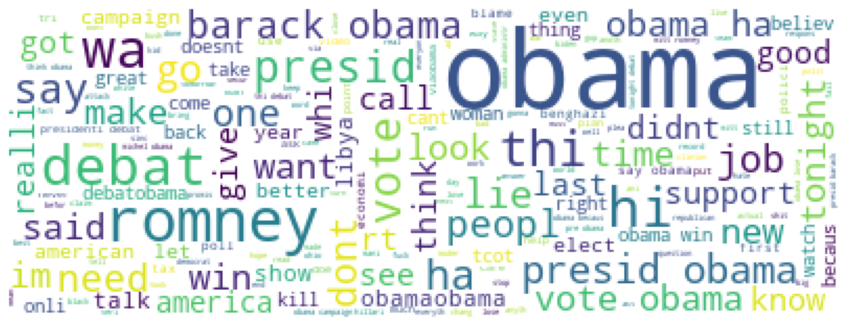

In [15]:
# Remove stopword
oba_rmstop = tweet_cleaning(tweets_oba, 'rm_stopwords')
print(oba_rmstop)
wordcloud(''.join(oba_rmstop))

['kirkpatrick wore baseb cap embroid barack obama signatur hangdog look jason segel courier journal'
 'obama debat cracker cracker tonight tune teamobama'
 'miss point im afraid understand bigger pictur dont care obama elect' ...
 'reason ann romney michel obama match last night michel obama ann romney show last nig'
 'obama kenakan cincin syahadat sejak sma'
 'bitch like obama3 bitch want food stamp lmao']


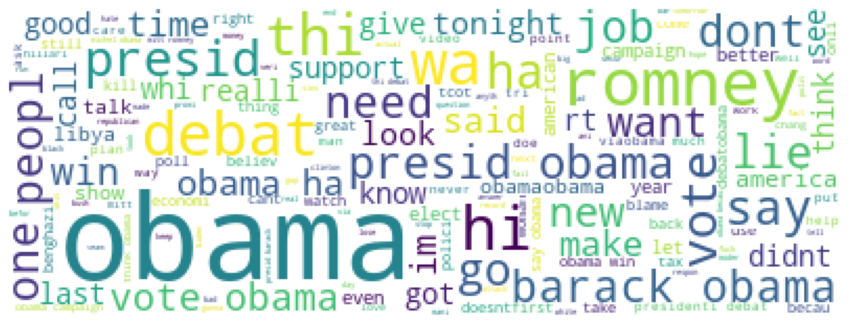

In [16]:
# All cleaning methods
oba_cleanall = tweet_cleaning(tweets_oba, 'all')
print(oba_cleanall)
wordcloud(''.join(oba_cleanall))

In [17]:
save_dataset(oba_cleanall, targets_oba, 'tweets_oba', 'targets_oba')

Saving training dataset...
Saved parsed dataset


## Romney's Tweets

In [18]:
tweets_rom, targets_rom = data_parse(df2)
tweets_rom.shape, targets_rom.shape

(7200, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 1 to 7200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7200 non-null   object
 1   Class   7200 non-null   object
dtypes: object(2)
memory usage: 168.8+ KB
None
-1      2893
0       1680
2       1351
1       1075
!!!!     169
nan       29
IR         3
Name: Class, dtype: int64
After extracting: (5648, 2)


((5648,), (5648,))

In [19]:
tweets_rom

array(["Insidious!<e>Mitt Romney</e>'s Bain Helped Philip Morris Get U.S. High Schoolers <a>Hooked On Cigarettes</a> http://t.co/nMKuFcUq via @HuffPostPol",
       '.@WardBrenda @shortwave8669 @allanbourdius you mean like <e>romney </e><a>cheated in primary</a>?',
       "<e>Mitt Romney</e> still doesn't <a>believe</a> that we <a>have a black president</a>.",
       ...,
       'el 59 por ciento de las mujeres blancas casadas respaldan a <e>Romney</e>"""',
       '"And they brought us a whole binder of women"""" oh <e>Romney</e>"""',
       '@FoxNews <e>Romney</e>won"""'], dtype=object)

## WordCloud for Rom_tweet

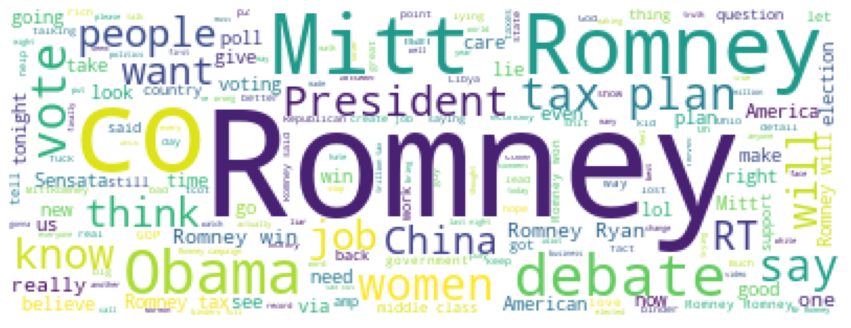

In [20]:
wordcloud(' '.join(tweets_rom))

['insidiousmitt romneys bain helped philip morris get us high schoolers hooked on cigarettes via '
 ' you mean like romney cheated in primary'
 'mitt romney still doesnt believe that we have a black president' ...
 'el 59 por ciento de las mujeres blancas casadas respaldan a romney'
 'and they brought us a whole binder of women oh romney' ' romneywon']


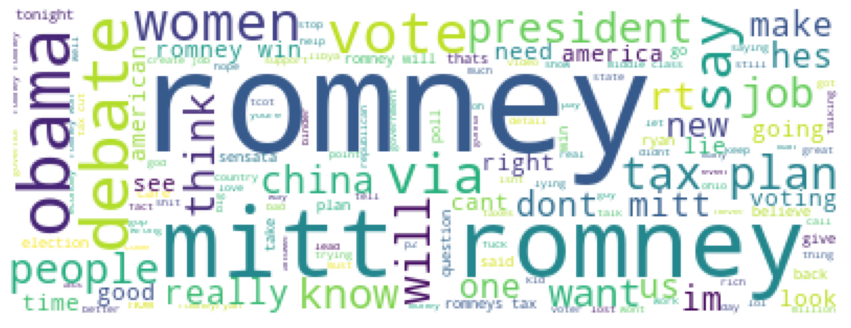

In [21]:
# Remove special char only
rom_rmspecial = tweet_cleaning(tweets_rom, '')
print(rom_rmspecial)
wordcloud(''.join(rom_rmspecial))

['insidiousmitt romney bain help philip morri get u high schooler hook on cigarett via'
 'you mean like romney cheat in primari'
 'mitt romney still doesnt believ that we have a black presid' ...
 'el 59 por ciento de la mujer blanca casada respaldan a romney'
 'and they brought u a whole binder of woman oh romney' 'romneywon']


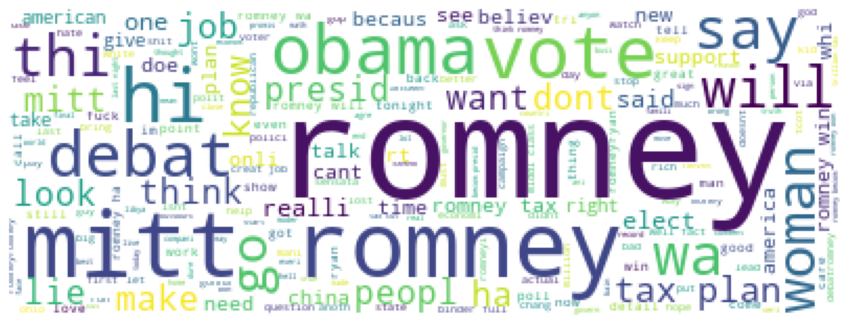

In [22]:
# Tweet stemmer_lemmatizer
rom_stemlem = tweet_cleaning(tweets_rom, 'stem_lem')
print(rom_stemlem)
wordcloud(''.join(rom_stemlem))

['insidiousmitt romney bain help philip morri get u high schooler hook cigarett via'
 'mean like romney cheat primari'
 'mitt romney still doesnt believ black presid' ...
 'el 59 por ciento de la mujer blanca casada respaldan romney'
 'brought u whole binder woman oh romney' 'romneywon']


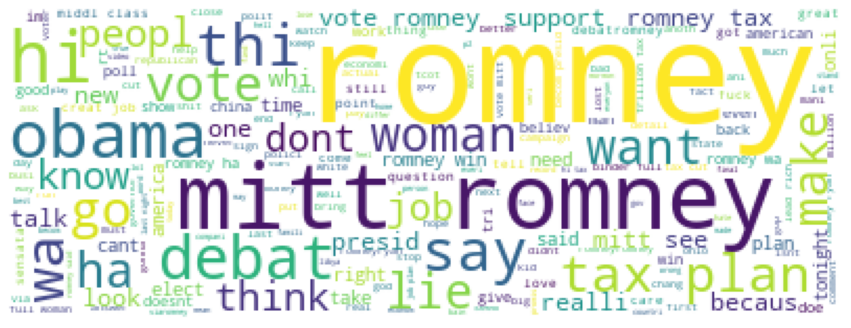

In [23]:
# Remove stopword
rom_rmstop = tweet_cleaning(tweets_rom, 'rm_stopwords')
print(rom_rmstop)
wordcloud(''.join(rom_rmstop))

['insidiousmitt romney bain help philip morri get u high schooler hook cigarett via'
 'mean like romney cheat primari'
 'mitt romney still doesnt believ black presid' ...
 'el 59 por ciento de la mujer blanca casada respaldan romney'
 'brought u whole binder woman oh romney' 'romneywon']


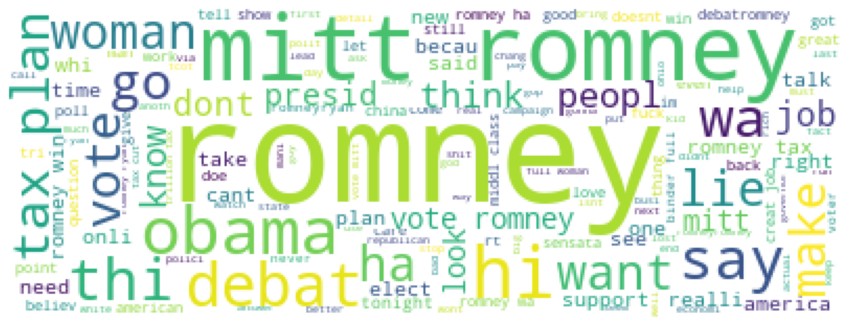

In [24]:
# All cleaning methods
rom_cleanall = tweet_cleaning(tweets_rom, 'all')
print(rom_cleanall)
wordcloud(''.join(rom_cleanall))

In [25]:
save_dataset(rom_cleanall, targets_rom, 'tweets_rom', 'targets_rom')

Saving training dataset...
Saved parsed dataset


## Data Vectorization

In [26]:
train_X, test_X, train_Y, test_Y = train_test_split(oba_cleanall, targets_oba, test_size = 0.2, random_state = 42)

### TF-IDF vectorizer

In [27]:
#tfv = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
tfv = TfidfVectorizer()
train_tfv = tfv.fit_transform(train_X)
test_tfv = tfv.transform(test_X)

In [28]:
vocab = tfv.get_feature_names()
print(vocab[:5])
print("Vocabulary length:", len(vocab))
dist = np.sum(train_tfv, axis=0)
checking = pd.DataFrame(dist, columns = vocab)
checking

['0023washington', '008', '0140648148148148', '0232002314814815', '047']
Vocabulary length: 6486


,0023washington,008,0140648148148148,0232002314814815,047,07,08,09,0908070500,09it,...,zerohedg,zesti,zien,zinger,zippedexcept,zipper,zombi,zwei,zzz,zzzzzzzzzz
0,0.228129,0.391409,0.265044,0.218621,0.397526,0.382859,2.800123,0.305436,0.241071,0.339823,...,0.481229,0.574698,0.262856,0.415605,0.39194,0.369542,0.902087,0.353309,0.581842,0.992774


In [29]:
tfv.idf_

array([8.7186855, 8.7186855, 8.7186855, ..., 8.7186855, 8.7186855,
       8.7186855])

### Count Vector

In [30]:
cv = CountVectorizer()
train_cv = cv.fit_transform(train_X)
test_cv = cv.transform(test_X)

In [31]:
cvocab = cv.get_feature_names()
print(cvocab[:5])

['0023washington', '008', '0140648148148148', '0232002314814815', '047']


### Train Models

In [33]:
MLP = MLPClassifier(random_state = 42)

mlp_param_grid = {
    'hidden_layer_sizes':[(5)],
    'activation':['relu'],
    'solver':['adam'],
    'alpha':[0.3],
    'learning_rate':['constant'],
    'max_iter':[1000]
}

kfold = StratifiedKFold( n_splits = 5, random_state = 42, shuffle=True )
gsMLP = GridSearchCV(MLP, param_grid = mlp_param_grid, cv = kfold, n_jobs= 1, verbose = 1)
gsMLP.fit(train_tfv, train_Y)
print(gsMLP.best_params_)
mlp_best0 = gsMLP.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'activation': 'relu', 'alpha': 0.3, 'hidden_layer_sizes': 5, 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.8s finished


In [34]:
gsMLP.best_score_
MLP_Y_predict = gsMLP.predict(test_tfv)
print("MLP classifier")
print(classification_report(MLP_Y_predict,test_Y))

MLP classifier
              precision    recall  f1-score   support

          -1       0.62      0.57      0.59       424
           0       0.51      0.54      0.52       371
           1       0.55      0.57      0.56       330

    accuracy                           0.56      1125
   macro avg       0.56      0.56      0.56      1125
weighted avg       0.56      0.56      0.56      1125



In [35]:
from sklearn import linear_model

logisticReg = linear_model.LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
logisticReg.fit(train_tfv, train_Y)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [36]:
Y_predict=logisticReg.predict(test_tfv)

In [37]:
print("LogisticRegression")
print(classification_report(Y_predict,test_Y))

LogisticRegression
              precision    recall  f1-score   support

          -1       0.62      0.58      0.60       414
           0       0.51      0.56      0.53       361
           1       0.60      0.59      0.60       350

    accuracy                           0.58      1125
   macro avg       0.58      0.58      0.58      1125
weighted avg       0.58      0.58      0.58      1125



In [38]:
from sklearn import svm
clf = svm.LinearSVC(max_iter=2000)
clf.fit(train_tfv, train_Y)

LinearSVC(max_iter=2000)

In [39]:
clf_Y_predict = clf.predict(test_tfv)
print("Linear Support Vector Classification")
print(classification_report(clf_Y_predict,test_Y))

Linear Support Vector Classification
              precision    recall  f1-score   support

          -1       0.62      0.57      0.60       421
           0       0.51      0.54      0.52       368
           1       0.57      0.59      0.58       336

    accuracy                           0.57      1125
   macro avg       0.57      0.57      0.57      1125
weighted avg       0.57      0.57      0.57      1125



In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

print("RandomForestClassifier")
print(classification_report(y_pred,test_Y))

Training Accuracy : 0.9919982218270726
Validation Accuracy : 0.5813333333333334
[[221 106  61]
 [ 91 225  76]
 [ 45  92 208]]
RandomForestClassifier
              precision    recall  f1-score   support

          -1       0.57      0.62      0.59       357
           0       0.57      0.53      0.55       423
           1       0.60      0.60      0.60       345

    accuracy                           0.58      1125
   macro avg       0.58      0.58      0.58      1125
weighted avg       0.58      0.58      0.58      1125



In [42]:
model = DecisionTreeClassifier()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

print("DecisionTreeClassifier")
print(classification_report(y_pred,test_Y))

Training Accuracy : 0.9919982218270726
Validation Accuracy : 0.49422222222222223
[[196 114  78]
 [107 186  99]
 [ 74  97 174]]
DecisionTreeClassifier
              precision    recall  f1-score   support

          -1       0.51      0.52      0.51       377
           0       0.47      0.47      0.47       397
           1       0.50      0.50      0.50       351

    accuracy                           0.49      1125
   macro avg       0.49      0.49      0.49      1125
weighted avg       0.49      0.49      0.49      1125



In [75]:
from sklearn.svm import SVC

model = SVC()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

Training Accuracy : 0.960213380751278
Validation Accuracy : 0.5902222222222222
[[260  90  38]
 [115 221  56]
 [ 71  91 183]]


In [32]:
kfold = StratifiedKFold( n_splits = 5, random_state = 42, shuffle=True )
print(kfold)
sv = LinearSVC(random_state=2018)

param_grid2 = {
    'loss':['squared_hinge'],
    'class_weight':[{1:4}],
    'C': [0.2]
}
sv.fit(train_tfv, train_Y)
accuracy_score(test_Y, sv.predict(test_tfv))

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


0.568

In [44]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
Y_pred_Bayes = gnb.fit(train_tfv.toarray(), train_Y).predict(test_tfv.toarray())

In [45]:
print("Gaussian Naive Bayes")
print(classification_report(Y_pred_Bayes,test_Y))

Gaussian Naive Bayes
              precision    recall  f1-score   support

          -1       0.45      0.49      0.47       360
           0       0.26      0.44      0.32       228
           1       0.67      0.43      0.53       537

    accuracy                           0.45      1125
   macro avg       0.46      0.45      0.44      1125
weighted avg       0.52      0.45      0.47      1125

